In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import seaborn as sns
from fractions import Fraction
import subprocess
from tqdm.auto import tqdm 
import uuid
import matplotlib.image as mpimg
from PIL import Image
from fractions import Fraction
from google import genai
from google.genai import types
import os
import base64
import multiprocessing
import json

In [2]:
tqdm.pandas()

In [3]:
def get_all_kf_stats(folder: Path = Path("kf_stats")):
    csvs = glob.glob(str(folder / "*.csv"))
    out_df = None
    for i, csv in enumerate(csvs):
        params = dict([x.split("=") for x in Path(csv).parts[-1].split("_")[2:]])
        df = pd.read_csv(csv, dtype={
            "path": str,
            "frame_count": "Int64",
            "uniform_frames": "Int64",
            "key_frames": "Int64",
        })
        df["scenecut"] = int(params["sc"])
        if i == 0:
            out_df = df
        else:
            out_df = pd.concat([out_df, df], ignore_index=True)
    return out_df

In [4]:
def map_color(df, col):
    color_d = dict(zip(df[col].unique(), sns.color_palette("hls", df[col].nunique())))
    df['color'] = df[col].map(color_d)
    return df

In [5]:
def get_frame_rate(path: Path) -> Fraction:
    if path.is_dir():
        return Fraction(3)
    cmd = [
        "ffprobe",
        "-v",
        "error",
        "-select_streams",
        "v:0",
        "-show_entries",
        "stream=r_frame_rate",
        "-of",
        "default=noprint_wrappers=1:nokey=1",
        str(path),
    ]

    try:
        output = subprocess.check_output(cmd).decode("utf-8").strip()
        return Fraction(output)
    except Exception as e:
        print(f"Error getting frame rate: {e}")
        return Fraction(0)

In [6]:
target_rate = Fraction(1)
compression_ratio = Fraction(2)
def extra_video_stats(p: str):
    p = Path(p)
    video_fr = get_frame_rate(p)
    min_scene_len = np.ceil(float(video_fr / target_rate))
    max_scene_len = np.ceil(float(video_fr / target_rate * compression_ratio))
    return pd.Series({"frame_rate": float(video_fr), "min_scene": int(min_scene_len) , "max_scene": int(max_scene_len)})

In [7]:
kf_df = get_all_kf_stats()
unique_paths = kf_df['path'].unique()
unique_df = pd.DataFrame(unique_paths, columns=['path'])

stats_cols = unique_df['path'].progress_apply(extra_video_stats)
unique_df = pd.concat([unique_df, stats_cols], axis=1)
kf_df = kf_df.merge(unique_df, on='path', how='left')
kf_df

  0%|          | 0/3499 [00:00<?, ?it/s]

,path,frame_count,uniform_frames,key_frames,scenecut,frame_rate,min_scene,max_scene
0,data/MVBench/video/tvqa/frames_fps3_hq/house_s...,299,99,86,180,3.0,3.0,6.0
1,data/MVBench/video/tvqa/frames_fps3_hq/s08e20_...,179,59,46,180,3.0,3.0,6.0
2,data/MVBench/video/tvqa/frames_fps3_hq/friends...,176,58,46,180,3.0,3.0,6.0
3,data/MVBench/video/tvqa/frames_fps3_hq/friends...,185,61,48,180,3.0,3.0,6.0
4,data/MVBench/video/tvqa/frames_fps3_hq/s01e17_...,185,61,48,180,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...
38484,data/MVBench/video/ssv2_video/220410.webm,42,3,2,0,12.0,12.0,24.0
38485,data/MVBench/video/ssv2_video/214227.webm,47,3,2,0,12.0,12.0,24.0
38486,data/MVBench/video/ssv2_video/203018.webm,52,4,3,0,12.0,12.0,24.0
38487,data/MVBench/video/ssv2_video/131887.webm,44,3,2,0,12.0,12.0,24.0


In [8]:
kf_df["frame_reduction_ratio"] = kf_df["key_frames"] / (kf_df["uniform_frames"] + 1) # Add 1 to uniform frame sampling

In [9]:
kf_df["batch"] = kf_df["path"].map(Path).map(lambda x: x.parts[3])

In [10]:
batch_sc_df = kf_df.groupby(["batch", "scenecut"])["frame_reduction_ratio"].mean().reset_index().sort_values("scenecut")

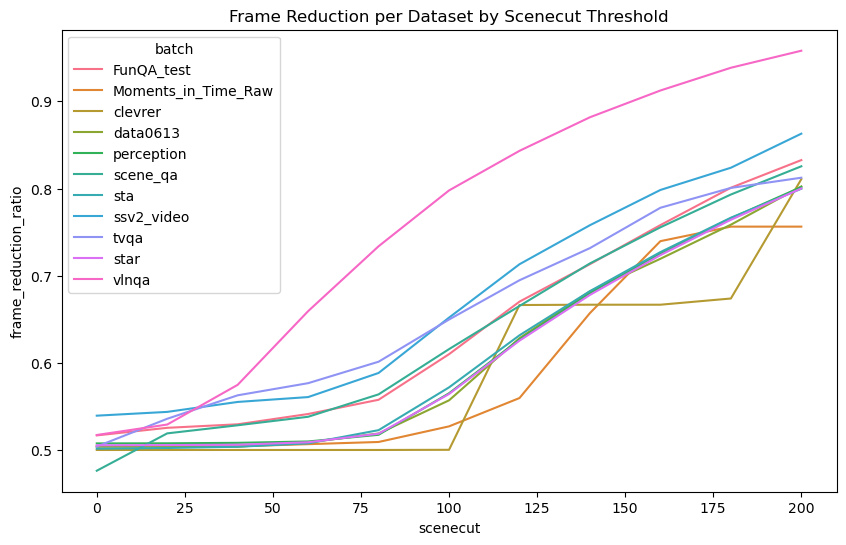

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=batch_sc_df,
    x="scenecut",
    y="frame_reduction_ratio",
    hue="batch",
    ax=ax
)
ax.set_title("Frame Reduction per Dataset by Scenecut Threshold")
plt.show()
fig.savefig("fr_sc_batch.png")

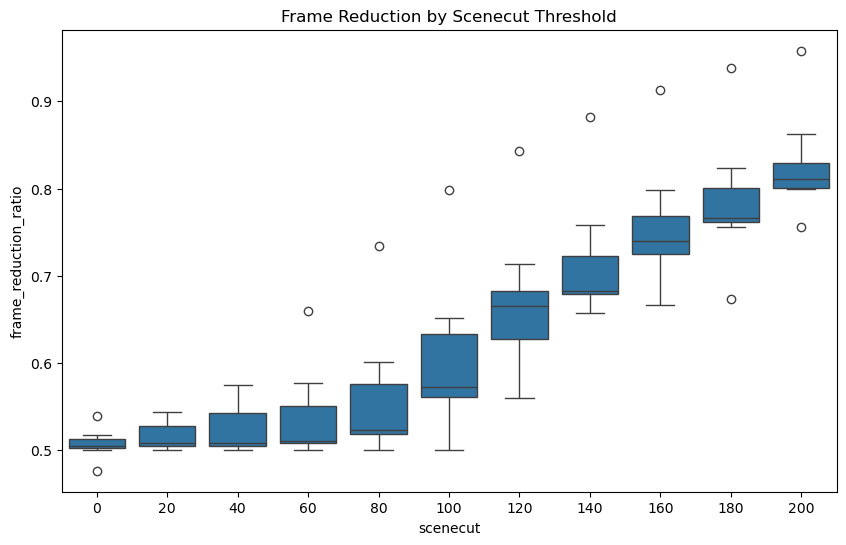

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=batch_sc_df,
    x="scenecut",
    y="frame_reduction_ratio",
    ax=ax
)
ax.set_title("Frame Reduction by Scenecut Threshold")
plt.show()
fig.savefig("fr_sc.png")

In [13]:
batch_sc_df[batch_sc_df["scenecut"] == 120].min()

batch                    FunQA_test
scenecut                        120
frame_reduction_ratio      0.559583
dtype: object

In [32]:
def get_frames(path: Path, frames: list[int]):
    prefix = str(uuid.uuid4())
    print(len(frames), "frames being processed")
    if path.is_dir():
        for f in frames:
            img = Image.open(path / f"{f+1:05d}.jpg")
            img.thumbnail((768, 768), Image.Resampling.LANCZOS) # Resize for optimal token usage w/ gemini
            img.save(f"ffmpeg/{prefix}_frame{f:04d}.jpg")
    else:
        frame_select_str = "+".join([f"eq(n\\,{x})" for x in frames])
        cmd = [
            "ffmpeg",
            "-i", str(path),
            "-v", "error",
            "-vsync", "0",
            "-vf", f"select={frame_select_str},scale=768:768:force_original_aspect_ratio=decrease", # Resize for optimal token usage w/ gemini
            "-q:v", "2",
            f"ffmpeg/{prefix}_frame%04d.jpg"
        ]
        subprocess.check_call(cmd)
    paths = glob.glob(f"ffmpeg/{prefix}*.jpg")
    return sorted(paths)

def get_uniform_frames(path: Path, total_frames: int, frames_per_sample: int) -> list[Path]:
    frame_idx = [i for i in range(0, total_frames, frames_per_sample)]
    return get_frames(path, frame_idx), frame_idx

def get_sampled_frames(path: Path, scenecut: int):
    json_path = Path(f"kf_info/{path.parts[3]}/kf_fps=1_ratio=2_sc={scenecut}_bframes=0.json")
    json = pd.read_json(json_path)
    frame_idx = json[json.path == str(path)].iloc[0].keyframes
    return get_frames(path, frame_idx), frame_idx

In [78]:
def compare_sampled_frames(data: pd.DataFrame, path: Path, scenecut: int):
    row = data[data.path == str(path)].iloc[0]
    uniform_frames, uniform_frames_idx = get_uniform_frames(path, int(row.frame_count), int(row.min_scene))
    h264_frames, h264_frames_idx = get_sampled_frames(path, scenecut)

    n_uniform = len(uniform_frames_idx)
    n_h264 = len(h264_frames_idx)
    n_cols = max(n_uniform, n_h264)

    print(n_uniform, n_h264)
    print(len(uniform_frames), len(h264_frames))
    
    fig, axes = plt.subplots(2, n_cols, figsize=(3.5 * n_cols, 6), squeeze=True)
    
    plt.suptitle(f"Frame Comparison between Uniform and H.264 FRS", fontsize=20)

    for i in range(n_cols):
        ax = axes[0, i]
        if i < n_uniform:
            idx = int(uniform_frames_idx[i])
            img = mpimg.imread(uniform_frames[i])
            ax.imshow(img)
            ax.set_title(f"Uniform\nFrame {idx}", fontsize=16)
        else:
            ax.axis('off')
        
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0: ax.set_ylabel("Uniform", fontsize=16, rotation=0, labelpad=40)

    for i in range(n_cols):
        ax = axes[1, i]
        if i < n_h264:
            idx = int(h264_frames_idx[i])
            img = mpimg.imread(h264_frames[i])
            ax.imshow(img)
            ax.set_title(f"H.264 (SC={scenecut})\nFrame {idx}", fontsize=16, y=-0.3)
        else:
            ax.axis('off')
            
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0: ax.set_ylabel("H.264", fontsize=16, rotation=0, labelpad=40)
    fig.tight_layout()
    plt.subplots_adjust(wspace=0)
    fig.savefig("frame_comparison.png", bbox_inches="tight")
    plt.show()
    # Delete temp files
    # if not path.is_dir():
    #     for f in uniform_frames:
    #         Path(f).unlink()
    #     for f in h264_frames:
    #         Path(f).unlink()

6 frames being processed
4 frames being processed
6 4
6 4


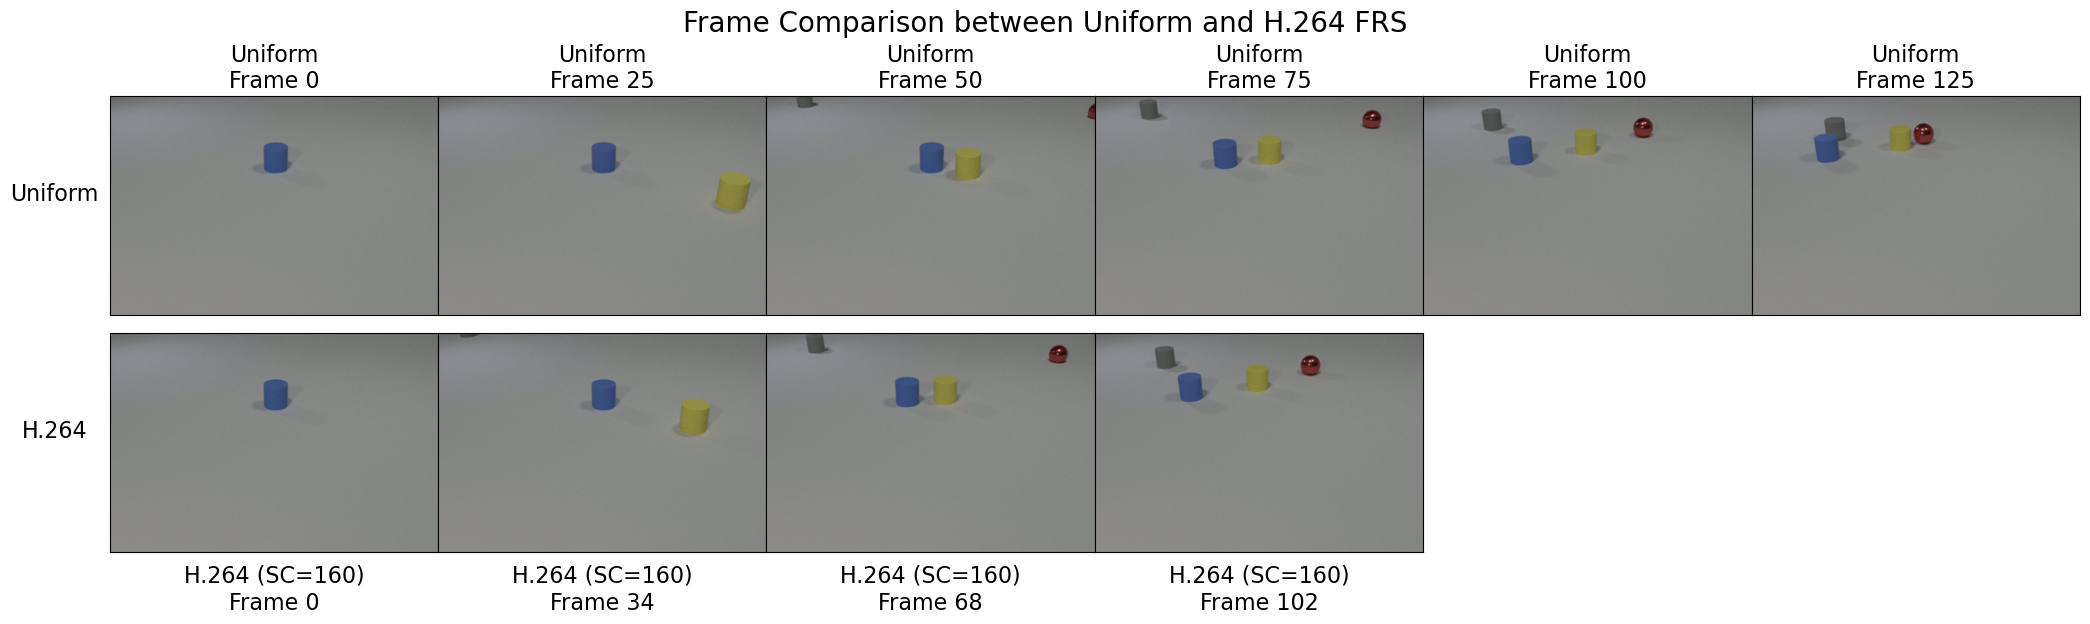

In [79]:
compare_sampled_frames(kf_df, Path(kf_df.iloc[201].path), 160)

In [17]:
kf_df.iloc[200]

path                     data/MVBench/video/clevrer/video_validation/vi...
frame_count                                                            128
uniform_frames                                                           5
key_frames                                                               4
scenecut                                                               180
frame_rate                                                            25.0
min_scene                                                             25.0
max_scene                                                             50.0
frame_reduction_ratio                                             0.666667
batch                                                              clevrer
Name: 200, dtype: object

In [404]:
# Repurposing some eval code from https://github.com/OpenGVLab/Ask-Anything/blob/main/video_chat2/mvbench.ipynb
data_list = {
    "Action Sequence": ("action_sequence.json", "data/MVBench/video/star/Charades_v1_480/", "video", True), # has start & end
    "Action Prediction": ("action_prediction.json", "data/MVBench/video/star/Charades_v1_480/", "video", True), # has start & end
    "Action Antonym": ("action_antonym.json", "data/MVBench/video/ssv2_video/", "video", False),
    "Fine-grained Action": ("fine_grained_action.json", "data/MVBench/video/Moments_in_Time_Raw/videos/", "video", False),
    "Unexpected Action": ("unexpected_action.json", "data/MVBench/video/FunQA_test/test/", "video", False),
    "Object Existence": ("object_existence.json", "data/MVBench/video/clevrer/video_validation/", "video", False),
    "Object Interaction": ("object_interaction.json", "data/MVBench/video/star/Charades_v1_480/", "video", True), # has start & end
    "Object Shuffle": ("object_shuffle.json", "data/MVBench/video/perception/videos/", "video", False),
    "Moving Direction": ("moving_direction.json", "data/MVBench/video/clevrer/video_validation/", "video", False),
    "Action Localization": ("action_localization.json", "data/MVBench/video/sta/sta_video/", "video", True),  # has start & end
    "Scene Transition": ("scene_transition.json", "data/MVBench/video/scene_qa/video/", "video", False),
    "Action Count": ("action_count.json", "data/MVBench/video/perception/videos/", "video", False),
    "Moving Count": ("moving_count.json", "data/MVBench/video/clevrer/video_validation/", "video", False),
    "Moving Attribute": ("moving_attribute.json", "data/MVBench/video/clevrer/video_validation/", "video", False),
    "State Change": ("state_change.json", "data/MVBench/video/perception/videos/", "video", False),
    # "Fine-grained Pose": ("fine_grained_pose.json", "data/MVBench/video/nturgbd/", "video", False), # TODO: obtain later?
    "Character Order": ("character_order.json", "data/MVBench/video/perception/videos/", "video", False),
    "Egocentric Navigation": ("egocentric_navigation.json", "data/MVBench/video/vlnqa/", "video", False),
    "Episodic Reasoning": ("episodic_reasoning.json", "data/MVBench/video/tvqa/frames_fps3_hq/", "frame", True),  # has start & end, read frame
    "Counterfactual Inference": ("counterfactual_inference.json", "data/MVBench/video/clevrer/video_validation/", "video", False),
}

data_dir = "data/MVBench/json"

In [127]:
def qa_template(data):
    question = f"Question: {data['question']}\n"
    question += "Options:\n"
    answer = data['answer']
    answer_idx = -1
    for idx, c in enumerate(data['candidates']):
        question += f"({chr(ord('A') + idx)}) {c}\n"
        if c == answer:
            answer_idx = idx
    question = question.rstrip()
    answer = f"({chr(ord('A') + answer_idx)}) {answer}"
    return question, answer

In [376]:
N_FFMPEG_THREADS=1

def get_frames(path: Path, frames: list[int]):
    prefix = str(uuid.uuid4())
    print(len(frames), "frames being processed")
    if path.is_dir():
        for f in frames:
            img = Image.open(path / f"{f+1:05d}.jpg")
            img.thumbnail((768, 768), Image.Resampling.LANCZOS) # Resize for optimal token usage w/ gemini
            img.save(f"ffmpeg/{prefix}_frame{f:04d}.jpg")
    else:
        frame_select_str = "+".join([f"eq(n\\,{x})" for x in frames])
        cmd = [
            "ffmpeg",
            "-i", str(path),
            "-v", "error",
            "-vf", f"select={frame_select_str}",
            "-vsync", "0",
            "-vf", "scale=768:768:force_original_aspect_ratio=decrease", # Resize for optimal token usage w/ gemini
            "-q:v", "2",
            f"ffmpeg/{prefix}_frame%04d.jpg"
        ]
        subprocess.check_call(cmd)
    paths = glob.glob(f"ffmpeg/{prefix}*.jpg")
    return sorted(paths)

def get_uniform_frames(path: Path, total_frames: int, frames_per_sample: int) -> list[Path]:
    frame_idx = [i for i in range(0, total_frames, frames_per_sample)]
    return get_frames(path, frame_idx), frame_idx

def get_sampled_frames(path: Path, scenecut: int):
    json_path = Path(f"kf_info/{path.parts[3]}/kf_fps=1_ratio=2_sc={scenecut}_bframes=0.json")
    json = pd.read_json(json_path)
    frame_idx = json[json.path == str(path)].iloc[0].keyframes
    return get_frames(path, frame_idx), frame_idx

def get_frame_rate(path: Path) -> Fraction:
    if path.is_dir():
        return Fraction(3)
    cmd = [
        "ffprobe",
        "-v",
        "error",
        "-select_streams",
        "v:0",
        "-show_entries",
        "stream=r_frame_rate",
        "-of",
        "default=noprint_wrappers=1:nokey=1",
        str(path),
    ]

    try:
        output = subprocess.check_output(cmd).decode("utf-8").strip()
        return Fraction(output)
    except Exception as e:
        print(f"Error getting frame rate: {e}")
        return Fraction(0)


def get_keyframes_ffmpeg(
    path: str,
    video_fr: Fraction,
    keyint_min: int = 8,
    keyint_max: int = 24,
    sc_threshold: int = 40,
    bframes: int = -1,  # -1 uses libx264 default of 3
    trim_start=None,
    trim_end=None
) -> tuple[list[int], int, int]:
    cmd = None
    p = Path(path)

    start_offset_frames = 0
    trim_args = []

    if trim_start is not None:
        start_offset_frames = int(round(trim_start * video_fr))
        trim_args.extend(["-ss", str(trim_start)])

    if trim_end is not None:
        trim_args.extend(["-to", str(trim_end)])
    
    
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-threads", str(N_FFMPEG_THREADS), # For parallel use
        *trim_args, 
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", str(p / "%05d.jpg"), 
        "-c:v", "libx264", 
        "-preset", "superfast",
        "-v", "error",
        "-vf", "scale=-2:360", # Make sure h/w is even
        "-x264-params", f"rc-lookahead={min(keyint_max, 60)}", # Full lookahead, capped for now just to get a full run in
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        *trim_args, 
        "-i", str(path), 
        "-c:v", "libx264", 
        "-preset", "superfast",
        "-threads", str(N_FFMPEG_THREADS), # For parallel use
        "-vf", "scale=-2:360", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-x264-params", f"rc-lookahead={min(keyint_max, 60)}", # Full lookahead, capped for now just to get a full run in
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]

    ffmpeg_process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        "-"
    ]
    
    output = subprocess.check_output(ffprobe_cmd, stdin=ffmpeg_process.stdout)
    ffmpeg_process.wait()

    lines = output.decode("utf-8").strip().split("\n")
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",")  # ffmpeg does trailing commas sometimes
        if not line:
            continue
        items = line.split(",")
        frame_count += 1
        if "I" in items and "1" in items:
            idr_indices.append(i + start_offset_frames)
            idr_count += 1
    return idr_indices, idr_count, frame_count


In [175]:
kfs

[5, 9, 15, 19, 24, 30, 35]

In [193]:
pd.read_json("data/MVBench/json/episodic_reasoning.json").iloc[0]

'castle_s07e04_seg02_clip_14'

In [194]:
kf_df.iloc[0].path

'data/MVBench/video/tvqa/frames_fps3_hq/house_s03e11_seg02_clip_08'

In [372]:
def get_uniform_frames_trim(path: Path, total_frames: int, frames_per_sample: int, video_fr: Fraction, start = None, end = None) -> list[Path]:
    print("path", path, "total frames", total_frames, "spacing", frames_per_sample, "fr", video_fr, "start", start, "end", end)
    start_frame = int(round(float(Fraction(start) * video_fr))) if start is not None else 0
    end_frame = int(np.floor(float(Fraction(end) * video_fr))) if end is not None else total_frames
    print(start_frame, end_frame)
    frame_idx = [i for i in range(start_frame, end_frame + 1, frames_per_sample)]
    print("frame idx created", len(frame_idx))
    return get_frames(path, frame_idx), frame_idx
    

In [185]:
get_uniform_frames_trim(Path("data/MVBench/video/tvqa/frames_fps3_hq/house_s03e11_seg02_clip_08"), 299, 3, Fraction(3), start=5, end=12)

(['ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0015.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0018.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0021.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0024.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0027.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0030.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0033.jpg',
  'ffmpeg/734c52a9-aa6f-4409-a7e5-2264f6cff77f_frame0036.jpg'],
 [15, 18, 21, 24, 27, 30, 33, 36])

In [188]:
get_keyframes_ffmpeg(
    Path("data/MVBench/video/tvqa/frames_fps3_hq/house_s03e11_seg02_clip_08"),
    Fraction(3),
    3,
    6,
    80,
    0,
    trim_start=5,
    trim_end=12
)

([15, 19, 24, 30, 35], 5, 21)

In [454]:
N_FFMPEG_THREADS=1
N_PARALLEL=4

def get_frames(path: Path, frames: list[int]):
    prefix = str(uuid.uuid4())
    if path.is_dir():
        for f in frames:
            img = Image.open(path / f"{f+1:05d}.jpg")
            img.thumbnail((768, 768), Image.Resampling.LANCZOS) # Resize for optimal token usage w/ gemini
            img.save(f"ffmpeg/{prefix}_frame{f:04d}.jpg")
    else:
        frame_select_str = "+".join([f"eq(n\\,{x})" for x in frames])
        cmd = [
            "ffmpeg",
            "-i", str(path),
            "-v", "error",
            "-vf", f"select={frame_select_str},scale=768:768:force_original_aspect_ratio=decrease", # Resize for optimal token usage w/ gemini
            "-vsync", "0",
            "-q:v", "2",
            f"ffmpeg/{prefix}_frame%04d.jpg"
        ]
        subprocess.check_call(cmd)
    paths = glob.glob(f"ffmpeg/{prefix}*.jpg")
    return sorted(paths)

def get_uniform_frames(path: Path, total_frames: int, frames_per_sample: int) -> list[Path]:
    frame_idx = [i for i in range(0, total_frames, frames_per_sample)]
    return get_frames(path, frame_idx), frame_idx

def get_sampled_frames(path: Path, scenecut: int):
    json_path = Path(f"kf_info/{path.parts[3]}/kf_fps=1_ratio=2_sc={scenecut}_bframes=0.json")
    json = pd.read_json(json_path)
    frame_idx = json[json.path == str(path)].iloc[0].keyframes
    return get_frames(path, frame_idx), frame_idx

def get_frame_rate(path: Path) -> Fraction:
    if path.is_dir():
        return Fraction(3)
    cmd = [
        "ffprobe",
        "-v",
        "error",
        "-select_streams",
        "v:0",
        "-show_entries",
        "stream=r_frame_rate",
        "-of",
        "default=noprint_wrappers=1:nokey=1",
        str(path),
    ]

    try:
        output = subprocess.check_output(cmd).decode("utf-8").strip()
        return Fraction(output)
    except Exception as e:
        print(f"Error getting frame rate: {e}")
        return Fraction(0)


def get_keyframes_ffmpeg(
    path: str,
    video_fr: Fraction,
    keyint_min: int = 8,
    keyint_max: int = 24,
    sc_threshold: int = 40,
    bframes: int = -1,  # -1 uses libx264 default of 3
    trim_start=None,
    trim_end=None
) -> tuple[list[int], int, int]:
    cmd = None
    p = Path(path)

    start_offset_frames = 0
    trim_args = []

    if trim_start is not None:
        start_offset_frames = int(round(trim_start * video_fr))
        trim_args.extend(["-ss", str(trim_start)])

    if trim_end is not None:
        trim_args.extend(["-to", str(trim_end)])
    
    
    if p.is_dir():
        cmd = [
        "ffmpeg", 
        "-threads", str(N_FFMPEG_THREADS), # For parallel use
        *trim_args, 
        "-framerate", "3", # tvqa videos all are at 3 fps
        "-i", str(p / "%05d.jpg"), 
        "-c:v", "libx264", 
        "-preset", "superfast",
        "-v", "error",
        "-vf", "scale=-2:360", # Make sure h/w is even
        "-x264-params", f"rc-lookahead={min(keyint_max, 60)}", # Full lookahead, capped for now just to get a full run in
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]
    else:
        cmd = [
        "ffmpeg", 
        "-v", "error",
        *trim_args, 
        "-i", str(path), 
        "-c:v", "libx264", 
        "-preset", "superfast",
        "-threads", str(N_FFMPEG_THREADS), # For parallel use
        "-vf", "scale=-2:360", # Make sure h/w is even
        "-g", str(keyint_max), 
        "-keyint_min", str(keyint_min), 
        "-x264-params", f"rc-lookahead={min(keyint_max, 60)}", # Full lookahead, capped for now just to get a full run in
        "-sc_threshold", str(sc_threshold), 
        "-flags", "+cgop", # Use closed GOP to force frames to reference current 
        "-bf", str(bframes),
        "-f", "h264",
        "pipe:1",
    ]

    ffmpeg_process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    ffprobe_cmd = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "frame=pict_type,key_frame",
        "-of", "csv=p=0", 
        "-"
    ]
    
    output = subprocess.check_output(ffprobe_cmd, stdin=ffmpeg_process.stdout)
    ffmpeg_process.wait()

    lines = output.decode("utf-8").strip().split("\n")
    idr_indices = []
    frame_count = 0
    idr_count = 0
    for i, line in enumerate(lines):
        line = line.strip(",")  # ffmpeg does trailing commas sometimes
        if not line:
            continue
        items = line.split(",")
        frame_count += 1
        if "I" in items and "1" in items:
            idr_indices.append(i + start_offset_frames)
            idr_count += 1
    return idr_indices, idr_count, frame_count


def get_uniform_frames_trim(path: Path, total_frames: int, frames_per_sample: int, video_fr: Fraction, start = None, end = None) -> list[Path]:
    start_frame = int(round(float(Fraction(start) * video_fr))) if start is not None else 0
    end_frame = int(np.floor(float(Fraction(end) * video_fr))) if end is not None else total_frames
    if end_frame == total_frames: # Happened once on task 18/19 of the eval and I almost cried
        end_frame = total_frames - 1
    frame_idx = [i for i in range(start_frame, end_frame + 1, frames_per_sample)]
    return get_frames(path, frame_idx), frame_idx
    
def qa_template(question, candidates, answer):
    question = f"Question: {question}\n"
    question += "Options:\n"
    answer_idx = -1
    for idx, c in enumerate(candidates):
        question += f"({chr(ord('A') + idx)}) {c}\n"
        if c == answer:
            answer_idx = idx
    question = question.rstrip()
    answer = chr(ord('A') + answer_idx)
    return question, answer

def prompt_gemini_mvbench(keyframes, question, candidates, answer):
    question, answer = qa_template(question, candidates, answer)
    system_prompt = "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, \
    and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n"
    question_prompt="\nOnly give the best option."
    full_prompt = question + question_prompt

    client = genai.Client()

    file_sizes = [os.path.getsize(kf) for kf in keyframes]

    inline = False
    # Inline files if sub 15 MB
    if sum(file_sizes) < 15_000_000:
        inline = True
        remote_kfs = [Image.open(kf) for kf in keyframes]
    else:
        remote_kfs = [client.files.upload(file=kf) for kf in keyframes]
    
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[full_prompt, *remote_kfs],
        config=types.GenerateContentConfig(
            system_instruction=system_prompt,
        )
    )

    if not inline:
        for kf in remote_kfs:
            client.files.delete(name=kf.name)

    token_count = list(filter(lambda x: x.modality == types.MediaModality.IMAGE, response.usage_metadata.prompt_tokens_details))[0].token_count

    text_list = response.text.split("(")
    correct = False if len(text_list) < 2 or text_list[1][0] != answer else True
    return response.text, token_count, correct


# 1 FPS baseline, uses some pre-calc'ed frame counts from earlier
def process_single_example(args):
    video_dir, row, i, trimmed, category = args
    video_path = Path(video_dir) / Path(row.video)
    ref_rows =  kf_df[kf_df.path == str(video_path)]
    if len(ref_rows) == 0:
        supp_glob = str(Path("data/MVBench/video/data0613/*/**/") / Path(row.video))
        print("No match found for file", video_path,  "checking supplementary folder...:")
        extra_data = glob.glob(supp_glob)
        if len(extra_data) == 0:
            print("File not found at all! That's not great")
            return None
        else:
            print("Substitute file found:", extra_data[0])
            video_path = Path(extra_data[0])
            ref_rows =  kf_df[kf_df.path == str(video_path)]
    ref_row = ref_rows.iloc[0]
    video_fr = ref_row.frame_rate
    video_fc = int(ref_row.frame_count)
    if trimmed:
        video_frames, frame_idxs = get_uniform_frames_trim(video_path, video_fc, int(ref_row.min_scene), Fraction(video_fr), start=row.start, end=row.end)
    else:
        video_frames, frame_idxs = get_uniform_frames_trim(video_path, video_fc, int(ref_row.min_scene), Fraction(video_fr))
    response, token_count, correct = prompt_gemini_mvbench(video_frames, row.question, row.candidates, row.answer)
    result = {
        "video": video_path,
        "category": category,
        "qid": i,
        "question": row.question,
        "candidates": row.candidates,
        "answer_gt": row.answer,
        "answer_pred": response,
        "correct": correct,
        "token_count": token_count,
        "frame_count": len(frame_idxs)
    }
    for f in video_frames:
        os.remove(f)
    return result

def run_mvbench_category_baseline(mv_df: pd.DataFrame, category: str, video_dir: Path, trimmed: bool):
    results = []
    total_correct = 0
    pbar = tqdm(mv_df.iterrows(), total=mv_df.shape[0])
    all_args = [(video_dir, row, i, trimmed, category) for i, row in mv_df.iterrows()]
    # with multiprocessing.Pool(N_PARALLEL) as p:
    #     results = list(tqdm(p.imap(process_single_example, all_args), total=mv_df.shape[0]))
    #     total_correct = sum(map(lambda x: x.correct if x is not None else 0, results))
    #     return results, total_correct / len(mv_df)
    results = list(tqdm(map(process_single_example, all_args), total=mv_df.shape[0]))
    total_correct = sum(map(lambda x: x["correct"] if x is not None else 0, results))
    return results, total_correct / len(mv_df)


def run_mvbench_baseline():
    all_results = []
    all_avgs = []
    for i, category in enumerate(data_list):
        json, video_dir, _, trimmed = data_list[category]
        print(f"({i + 1:02d}/20) Starting", category, )
        
        df = pd.read_json(Path(data_dir) / Path(json))
        results, correct_avg = run_mvbench_category_baseline(df, category, video_dir, trimmed)
        all_results.append(results)
        all_avgs.append(correct_avg)
        print("Finished", category)
        print("Average correct:", correct_avg)
    print("Done")
    return all_results, all_avgs

In [455]:
results, avgs = run_mvbench_baseline()
pd.DataFrame(results).to_json("mvbench_baseline.json")

(01/20) Starting Action Sequence


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

No match found for file data/MVBench/video/star/Charades_v1_480/EDXBD.mp4 checking supplementary folder...:
Substitute file found: data/MVBench/video/data0613/star/Charades_v1_480/EDXBD.mp4
No match found for file data/MVBench/video/star/Charades_v1_480/K47J5.mp4 checking supplementary folder...:
Substitute file found: data/MVBench/video/data0613/star/Charades_v1_480/K47J5.mp4
No match found for file data/MVBench/video/star/Charades_v1_480/9MNZ5.mp4 checking supplementary folder...:
Substitute file found: data/MVBench/video/data0613/star/Charades_v1_480/9MNZ5.mp4
No match found for file data/MVBench/video/star/Charades_v1_480/QXT9W.mp4 checking supplementary folder...:
Substitute file found: data/MVBench/video/data0613/star/Charades_v1_480/QXT9W.mp4
No match found for file data/MVBench/video/star/Charades_v1_480/ABHC6.mp4 checking supplementary folder...:
Substitute file found: data/MVBench/video/data0613/star/Charades_v1_480/ABHC6.mp4
No match found for file data/MVBench/video/star/Ch

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Process SpawnPoolWorker-104:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/ee274-project/lib/python3.13/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
    ~~~~~~~~^^
  File "/opt/miniconda3/envs/ee274-project/lib/python3.13/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/ee274-project/lib/python3.13/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/miniconda3/envs/ee274-project/lib/python3.13/multiprocessing/queues.py", line 384, in get
    with self._rlock:
         ^^^^^^^^^^^
  File "/opt/miniconda3/envs/ee274-project/lib/python3.13/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ~~~~~~~~~~~~~~~~~~~~~~~^^
KeyboardInterrupt


KeyboardInterrupt: 

In [321]:
file = Path("data/MVBench/video/tvqa/frames_fps3_hq/castle_s07e04_seg02_clip_14")
item = pd.read_json("data/MVBench/json/episodic_reasoning.json").iloc[0]
kfs, _ = get_uniform_frames_trim(file, 269, 3, Fraction(3), start=item.start, end=item.end)
text, metadata, correct = prompt_gemini_mvbench(kfs,item.question, item.candidates, item.answer)

Question: Why did Castle dress like a fairy when he was speaking to Emily?
Options:
(A) To get her to trust him
(B) He secretly loved fairies
(C) He lost a bet with Emily
(D) It was dress like a fairy day at school
(E) Mrs Ruiz made him dress up
Only give the best option.
Total file size 863066


  0%|          | 0/39 [00:00<?, ?it/s]

['', 'A)'] A


In [322]:
text, metadata, correct

('(A)', 10062, True)

In [314]:
text_list = text.split('(')
False if len(text_list) < 2 or text_list[1][0] != "A" else True

True

In [269]:
metadata.prompt_tokens_details

[ModalityTokenCount(
   modality=<MediaModality.TEXT: 'TEXT'>,
   token_count=125
 ),
 ModalityTokenCount(
   modality=<MediaModality.IMAGE: 'IMAGE'>,
   token_count=10062
 )]

In [195]:
file = Path("data/MVBench/video/tvqa/frames_fps3_hq/castle_s07e04_seg02_clip_14")


In [326]:
kf_df[kf_df.path == str(file)].iloc[0][["frame_count", "frame_rate", "min_scene"]]

frame_count    269
frame_rate     3.0
min_scene      3.0
Name: 44, dtype: object

In [201]:
item

video                               castle_s07e04_seg02_clip_14
question      Why did Castle dress like a fairy when he was ...
candidates    [To get her to trust him, He secretly loved fa...
answer                                  To get her to trust him
subtitle      (Castle:)you just use that strength, and just ...
show_name                                                Castle
start                                                       0.0
end                                                       38.32
fps                                                           3
Name: 0, dtype: object

In [240]:
kf_df[kf_df.uniform_frames > 100].path.unique()

array(['data/MVBench/video/tvqa/frames_fps3_hq/castle_s04e16_seg02_clip_01',
       'data/MVBench/video/tvqa/frames_fps3_hq/s03e12_seg01_clip_00',
       'data/MVBench/video/tvqa/frames_fps3_hq/grey_s03e09_seg02_clip_30',
       'data/MVBench/video/tvqa/frames_fps3_hq/house_s08e12_seg02_clip_25',
       'data/MVBench/video/tvqa/frames_fps3_hq/grey_s02e10_seg02_clip_20',
       'data/MVBench/video/tvqa/frames_fps3_hq/castle_s06e14_seg02_clip_26',
       'data/MVBench/video/tvqa/frames_fps3_hq/house_s03e24_seg02_clip_24',
       'data/MVBench/video/FunQA_test/test/test_creative/C_KT_97_6143_6339.mp4'],
      dtype=object)

<enum 'MediaModality'>

In [324]:
pd.read_json("data/MVBench/json/episodic_reasoning.json")

,video,question,candidates,answer,subtitle,show_name,start,end,fps
0,castle_s07e04_seg02_clip_14,Why did Castle dress like a fairy when he was ...,"[To get her to trust him, He secretly loved fa...",To get her to trust him,"(Castle:)you just use that strength, and just ...",Castle,0.00,38.32,3
1,s08e07_seg01_clip_00,Why is Amy so upset when Bernadette says she w...,"[She is jealous about Bernadette's looks. , Sh...",She thinks Bernadette should be recognized for...,"(Bernadette:)Anyway, I was asked to be a part ...",The Big Bang Theory,32.77,61.26,3
2,grey_s02e25_seg02_clip_11,What does Addison say it looked like when Mere...,[Addison said it looked like married couple at...,Addison said it looked like a lover's quarrel.,(Addison:)And I don't usually have trouble. Bu...,Grey's Anatomy,57.26,90.18,3
3,s07e05_seg02_clip_02,"Who knocked the door when Bernadette, Amy and ...","[Sheldon., Amy., Penny., Bernadette., Leonard.]",Sheldon.,(Sheldon:)You can't work where I work.\n(Sheld...,The Big Bang Theory,34.03,63.02,3
4,s02e23_seg02_clip_11,What did Mrs. Koothrappali say after Raj told ...,"[Have fun , Well then go , I don't care what t...",I don't care what the other guys are doing.,"(Sheldon:)I guess we're done here.Here, drink-...",The Big Bang Theory,0.00,34.32,3
...,...,...,...,...,...,...,...,...,...
195,house_s04e05_seg02_clip_20,Where is Thirteen putting the catheter into th...,"[In the patients foot., In the patients ear., ...",In the patients heart.,(House:)Hi. Cuddy called. She needs you to iro...,House M.D.,63.61,90.22,3
196,castle_s05e20_seg02_clip_07,Who is DArryl Meeks after investigating Ann's ...,"[DArryl Meek is a baseball player, Darryl Meek...",Darryl Meeks is a world famous Cryptozologist,(Castle:)So you're saying it's just a coincide...,Castle,20.26,46.36,3
197,met_s02e02_seg02_clip_12,Why Lily's art teacher was mad when he saw the...,"[Because the paint is blurry, Because Lily's p...",Because Lily's paint was bad.,(Man:)To say this is... Art...\n(Man:)I can't ...,How I Met You Mother,22.95,62.03,3
198,friends_s08e10_seg01_clip_00,Why does Rachel shush Chandler when Chandler t...,[Rachel shushes Chandler because she doesn't w...,Rachel shushes Chandler because the boots will...,"(Rachel:)-Oh, Monica, those boots are amazing....",Friends,32.65,57.82,3


In [416]:
kf_df[kf_df.path.str.startswith("data/MVBench/video/data0613")].iloc[0].path

'data/MVBench/video/data0613/clevrer/video_validation/video_13373.mp4'

In [426]:
glob.glob("data/MVBench/video/data0613/*/**/EDXBD.mp4")

['data/MVBench/video/data0613/star/Charades_v1_480/EDXBD.mp4']

In [474]:
def load_data(p):
    with open(p, "r", encoding="UTF-8") as file:
        data = json.load(file)
        all_values = [y for x in data for y in x.values()]
        return pd.DataFrame(all_values)

In [477]:
baseline = load_data("mvbench_baseline.json")
sc_80 = load_data("mvbench_sc=80.json")
sc_120 = load_data("mvbench_sc=120.json")

In [480]:
baseline_tokens = baseline["token_count"].sum()
sc_80_tokens = sc_80["token_count"].sum()
sc_120_tokens = sc_120["token_count"].sum()

In [481]:
baseline_tokens, sc_80_tokens, sc_120_tokens

(np.int64(16889454), np.int64(9393522), np.int64(11255766))

In [482]:
(baseline_tokens - sc_80_tokens) / baseline_tokens, (baseline_tokens - sc_120_tokens) / baseline_tokens, 

(np.float64(0.44382322838855537), np.float64(0.3335624704031285))